In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
import nltk
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn import preprocessing

### Get the dataset

In [2]:
data_dump = pd.read_csv("../../data/annotator_data_dump_with_polarity")
data_dump = data_dump[data_dump.polarity != 9].reset_index(drop=True)
data_dump = data_dump.drop(['category'], axis=1).drop_duplicates()

In [3]:
data = data_dump[["text", "polarity"]].dropna()

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(data["text"].values, data["polarity"].values)

## Data pre processing

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/mannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1368,), (1368,), (456,), (456,))

In [7]:
def text_prepare(texts):
    processed_texts = []
    for i, text in enumerate(texts):
        _text = text.lower()
        _text = re.compile('[/(){}\[\]\|@,;]').sub(r' ', _text)
        _text = re.compile('[^0-9a-z #+_]').sub(r'', _text)
        _text = ' '.join([word for word in _text.split() if word not in set(stopwords.words('english'))])
        processed_texts.append(_text)
    return processed_texts

def splitAndProcess(X, func, num_partitions, num_cores=4):
    df_split = np.array_split(np.array(X), num_partitions)
    pool = Pool(num_cores)
    X = np.concatenate(pool.map(func, df_split))
    pool.close()
    pool.join()
    return X

In [8]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_test, text_prepare, 8, 8)

In [9]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [10]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [11]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

('number of features: ', (1368, 73983), (456, 73983))


## Train:

In [13]:
#mlb = MultiLabelBinarizer(classes=[-1,0,1])
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(Y_train)
y_val = lb.fit_transform(Y_test)

### LR

In [14]:
LR_classifier = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
accuracy_score(y_val, LR_classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf))

0.5723684210526315

### SVM:

In [15]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf)
accuracy_score(y_val, y_pred_svm)

0.6447368421052632

## Feature importance: (Using LR classifier)

In [16]:
tfidf_vocab = tfidf_vectorizer.vocabulary_
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
def show_wordcloud(source, max_words=50):
    
    wordcloud = WordCloud(scale=4, max_words=1000)
    if type(source).__name__ == 'str' or type(source).__name__ == 'unicode':
        wordcloud.generate_from_text(source)
    else:
        wordcloud.generate_from_frequencies(source)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, number_of_words = 20):
    cof = classifier.estimators_[[-1,0,1].index(tag)].coef_
    top_negative_words = {}
    top_positive_words = {}
    for k in np.argsort(-cof[0])[:number_of_words]:
        top_positive_words[tfidf_reversed_vocab[k]] = cof[0][k]
        
    for k in np.argsort(cof[0])[:number_of_words]:
        top_negative_words[tfidf_reversed_vocab[k]] = cof[0][k]
        
    print("Tag:\t" + str(tag))
    print('positive words:\t{}'.format(', '.join(top_positive_words)))
    show_wordcloud(top_positive_words)
    print('negative words:\t{}\n'.format(', '.join(top_negative_words)))
    show_wordcloud(top_negative_words)

Tag:	-1
positive words:	said, police, government, fire, official, incident, infection, nea, high, death, attack, accused, accounts, jerusalem, found, plastic, data, children, condition, man


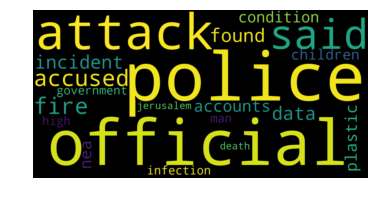

negative words:	development, hair, training, victory, apple, malaysia, club, app, sports, project, tv, game, breast, digital, talks, new, programme, breast cancer, exercise, first



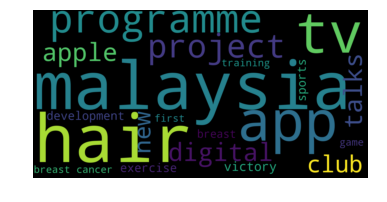

Tag:	0
positive words:	serve, set, age, users, samsung, career, winfrey, museum, mr, nutritional, ong, first, zoo, tv, music, digital, one, meals, galaxy, apple


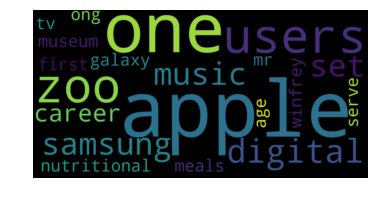

negative words:	fire, school, said, police, indian, cancer, government, students, internet, agency, blink, environment, society, train, health, treatment, child, japan, surgery, official



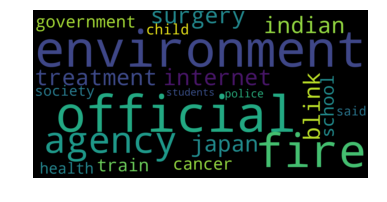

Tag:	1
positive words:	fuels, cakes, glaucoma, methods, schizophrenia, technology, nabin, training, game, foster, cardiac arrest, breast, team, device, security, women, breast cancer, hsieh, vision, cognitive


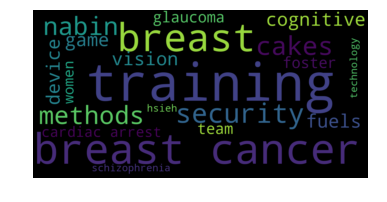

negative words:	case, kids, patient, apple, people, pain, global, doctor, infection, one, high, incident, spread, products, south, report, rare, data, condition, diabetes



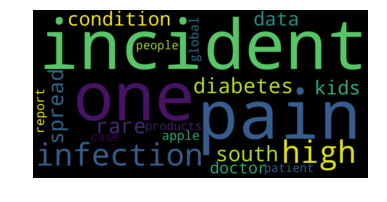

In [23]:
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
for key in [-1,0,1]:
    print_words_for_tag(classifier, key, [-1,0,1], tfidf_reversed_vocab)

### Classification report

In [24]:
from micromort.utils.classification_plotter import plot_classification_report

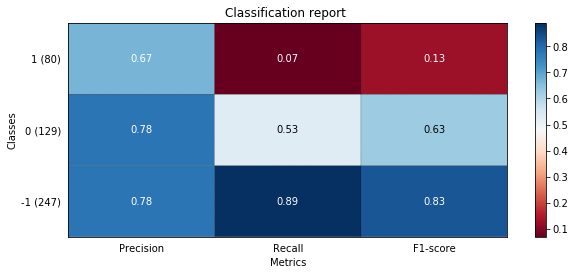

In [25]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names= [ "-1","0","1"]))

# Train on title

In [29]:
data = data_dump[["title", "polarity"]].dropna()

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(data["title"].values, data["polarity"].values)

## Data pre processing

In [31]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/mannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1385,), (1385,), (462,), (462,))

In [34]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_test, text_prepare, 8, 8)

In [35]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [36]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [37]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

('number of features: ', (1385, 2270), (462, 2270))


## Train:

In [38]:
#mlb = MultiLabelBinarizer(classes=[-1,0,1])
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(Y_train)
y_val = lb.fit_transform(Y_test)

### LR

In [39]:
LR_classifier = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
accuracy_score(y_val, LR_classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf))

0.474025974025974

### SVM:

In [40]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf)
accuracy_score(y_val, y_pred_svm)

0.47835497835497837

### Classification report

In [41]:
from micromort.utils.classification_plotter import plot_classification_report

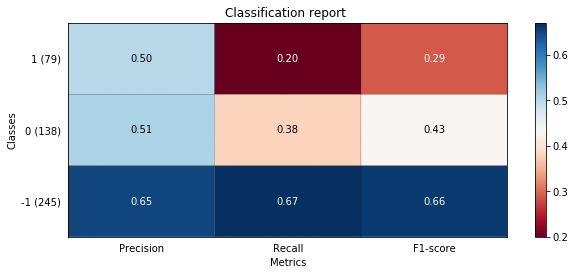

In [43]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names= [ "-1","0","1"]))

## XGBoost

In [78]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
# If you want to avoid the OneVsRestClassifier magic switch
# from sklearn.multioutput import MultiOutputClassifier

clf_multilabel = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)

In [79]:
clf_multilabel.fit(X_train_tfidf, y_train)

JoblibXGBoostError: JoblibXGBoostError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/usr/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f58e2940930, file "/...2.7/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f58e2940930, file "/...2.7/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
   1059                 self._events.update(event_pairs)
   1060                 while self._events:
   1061                     fd, events = self._events.popitem()
   1062                     try:
   1063                         fd_obj, handler_func = self._handlers[fd]
-> 1064                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
   1065                     except (OSError, IOError) as e:
   1066                         if errno_from_exception(e) == errno.EPIPE:
   1067                             # Happens when the client closes the connection
   1068                             pass

...........................................................................
/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf_multilabel.fit(X_train_tfidf, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 15, 2, 26, 17, 888382, tzinfo=tzutc()), 'msg_id': '03bb30e1a9c043598716c68c25c90685', 'msg_type': 'execute_request', 'session': '3704a7f481f049cd867341d582c2de5e', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '03bb30e1a9c043598716c68c25c90685', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['3704a7f481f049cd867341d582c2de5e']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf_multilabel.fit(X_train_tfidf, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 15, 2, 26, 17, 888382, tzinfo=tzutc()), 'msg_id': '03bb30e1a9c043598716c68c25c90685', 'msg_type': 'execute_request', 'session': '3704a7f481f049cd867341d582c2de5e', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '03bb30e1a9c043598716c68c25c90685', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['3704a7f481f049cd867341d582c2de5e'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf_multilabel.fit(X_train_tfidf, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 15, 2, 26, 17, 888382, tzinfo=tzutc()), 'msg_id': '03bb30e1a9c043598716c68c25c90685', 'msg_type': 'execute_request', 'session': '3704a7f481f049cd867341d582c2de5e', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '03bb30e1a9c043598716c68c25c90685', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'clf_multilabel.fit(X_train_tfidf, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'clf_multilabel.fit(X_train_tfidf, y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'clf_multilabel.fit(X_train_tfidf, y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'clf_multilabel.fit(X_train_tfidf, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'clf_multilabel.fit(X_train_tfidf, y_train)', store_history=True, silent=False, shell_futures=True)
   2709                 self.displayhook.exec_result = result
   2710 
   2711                 # Execute the user code
   2712                 interactivity = "none" if silent else self.ast_node_interactivity
   2713                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2714                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2715                 
   2716                 self.last_execution_succeeded = not has_raised
   2717 
   2718                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-79-db9e02ae3dba>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f5897451250, executi..._before_exec=None error_in_exec=None result=None>)
   2819                     return True
   2820 
   2821             for i, node in enumerate(to_run_interactive):
   2822                 mod = ast.Interactive([node])
   2823                 code = compiler(mod, cell_name, "single")
-> 2824                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f58940cdbb0, file "<ipython-input-79-db9e02ae3dba>", line 1>
        result = <ExecutionResult object at 7f5897451250, executi..._before_exec=None error_in_exec=None result=None>
   2825                     return True
   2826 
   2827             # Flush softspace
   2828             if softspace(sys.stdout, 0):

...........................................................................
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f58940cdbb0, file "<ipython-input-79-db9e02ae3dba>", line 1>, result=<ExecutionResult object at 7f5897451250, executi..._before_exec=None error_in_exec=None result=None>)
   2873         outflag = 1  # happens in more places, so it's easier as default
   2874         try:
   2875             try:
   2876                 self.hooks.pre_run_code_hook()
   2877                 #rprint('Running code', repr(code_obj)) # dbg
-> 2878                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f58940cdbb0, file "<ipython-input-79-db9e02ae3dba>", line 1>
        self.user_global_ns = {'Adam': <class 'keras.optimizers.Adam'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Embedding': <class 'keras.layers.embeddings.Embedding'>, 'In': ['', u'from sklearn.model_selection import train_test...t defaultdict\nfrom sklearn import preprocessing', u'data_dump = pd.read_csv("../../data/annotator_...p.drop([\'category\'], axis=1).drop_duplicates()', u'data = data_dump[["text", "polarity"]].dropna()', u'X_train, X_test, Y_train, Y_test = train_test_split(data["text"].values, data["polarity"].values)', u"nltk.download('stopwords')\nfrom nltk.corpus import stopwords", u'X_train.shape, Y_train.shape, X_test.shape, Y_test.shape', u"def text_prepare(texts):\n    processed_texts ...n    pool.close()\n    pool.join()\n    return X", u'X_train = splitAndProcess(X_train, text_prepar...al = splitAndProcess(X_test, text_prepare, 8, 8)', u"tfidf_vectorizer = TfidfVectorizer(min_df = .0...es(X):\n    return tfidf_vectorizer.transform(X)", u'X_train_tfidf = tfidf_features(X_train)\nX_val_tfidf = tfidf_features(X_val)', u'print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)', u'set(Y_train), set(Y_test)', u'#mlb = MultiLabelBinarizer(classes=[-1,0,1])\n...sform(Y_train)\ny_val = lb.fit_transform(Y_test)', u'LR_classifier = OneVsRestClassifier(LogisticRe...it(X_train_tfidf, y_train).predict(X_val_tfidf))', u'classifier = OneVsRestClassifier(LinearSVC(ran...(X_val_tfidf)\naccuracy_score(y_val, y_pred_svm)', u'tfidf_vocab = tfidf_vectorizer.vocabulary_\ntf...words)))\n    show_wordcloud(top_negative_words)', u'tfidf_reversed_vocab = {i:word for word,i in t...classifier, key, [-1,0,1], tfidf_reversed_vocab)', u'from micromort.utils.classification_plotter import plot', u'from micromort.utils.classification_plotter import plot_classification_report', ...], 'KeyedVectors': <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>, 'LR_classifier': OneVsRestClassifier(estimator=LogisticRegression...erbose=0, warm_start=False),
          n_jobs=-1), 'LSTM': <class 'keras.layers.recurrent.LSTM'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, ...}
        self.user_ns = {'Adam': <class 'keras.optimizers.Adam'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Embedding': <class 'keras.layers.embeddings.Embedding'>, 'In': ['', u'from sklearn.model_selection import train_test...t defaultdict\nfrom sklearn import preprocessing', u'data_dump = pd.read_csv("../../data/annotator_...p.drop([\'category\'], axis=1).drop_duplicates()', u'data = data_dump[["text", "polarity"]].dropna()', u'X_train, X_test, Y_train, Y_test = train_test_split(data["text"].values, data["polarity"].values)', u"nltk.download('stopwords')\nfrom nltk.corpus import stopwords", u'X_train.shape, Y_train.shape, X_test.shape, Y_test.shape', u"def text_prepare(texts):\n    processed_texts ...n    pool.close()\n    pool.join()\n    return X", u'X_train = splitAndProcess(X_train, text_prepar...al = splitAndProcess(X_test, text_prepare, 8, 8)', u"tfidf_vectorizer = TfidfVectorizer(min_df = .0...es(X):\n    return tfidf_vectorizer.transform(X)", u'X_train_tfidf = tfidf_features(X_train)\nX_val_tfidf = tfidf_features(X_val)', u'print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)', u'set(Y_train), set(Y_test)', u'#mlb = MultiLabelBinarizer(classes=[-1,0,1])\n...sform(Y_train)\ny_val = lb.fit_transform(Y_test)', u'LR_classifier = OneVsRestClassifier(LogisticRe...it(X_train_tfidf, y_train).predict(X_val_tfidf))', u'classifier = OneVsRestClassifier(LinearSVC(ran...(X_val_tfidf)\naccuracy_score(y_val, y_pred_svm)', u'tfidf_vocab = tfidf_vectorizer.vocabulary_\ntf...words)))\n    show_wordcloud(top_negative_words)', u'tfidf_reversed_vocab = {i:word for word,i in t...classifier, key, [-1,0,1], tfidf_reversed_vocab)', u'from micromort.utils.classification_plotter import plot', u'from micromort.utils.classification_plotter import plot_classification_report', ...], 'KeyedVectors': <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>, 'LR_classifier': OneVsRestClassifier(estimator=LogisticRegression...erbose=0, warm_start=False),
          n_jobs=-1), 'LSTM': <class 'keras.layers.recurrent.LSTM'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, ...}
   2879             finally:
   2880                 # Reset our crash handler in place
   2881                 sys.excepthook = old_excepthook
   2882         except SystemExit as e:

...........................................................................
/home/mannu/code/work/micromort/micromort/polarity_models/<ipython-input-79-db9e02ae3dba> in <module>()
----> 1 clf_multilabel.fit(X_train_tfidf, y_train)

...........................................................................
/home/mannu/code/work/micromort/virtualenv/lib/python2.7/site-packages/sklearn/multiclass.py in fit(self=OneVsRestClassifier(estimator=XGBClassifier(base...  silent=True, subsample=1),
          n_jobs=-1), X=<1368x75850 sparse matrix of type '<type 'numpy.... stored elements in Compressed Sparse Row format>, y=array([[1, 0, 0],
       [0, 1, 0],
       [1, 0...  [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]]))
    210         # of spawning threads.  See joblib issue #112.
    211         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
    212             self.estimator, X, column, classes=[
    213                 "not %s" % self.label_binarizer_.classes_[i],
    214                 self.label_binarizer_.classes_[i]])
--> 215             for i, column in enumerate(columns))
        columns = <generator object <genexpr>>
    216 
    217         return self
    218 
    219     @if_delegate_has_method('estimator')

...........................................................................
/home/mannu/code/work/micromort/virtualenv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
XGBoostError                                       Fri Jun 15 10:26:20 2018
PID: 22897                                   Python 2.7.12: /usr/bin/python
...........................................................................
/home/mannu/code/work/micromort/virtualenv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_binary>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), <1368x75850 sparse matrix of type '<type 'numpy.... stored elements in Compressed Sparse Row format>, array([1, 0, 1, ..., 0, 0, 0]))
        kwargs = {'classes': ['not 0', 0]}
        self.items = [(<function _fit_binary>, (XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), <1368x75850 sparse matrix of type '<type 'numpy.... stored elements in Compressed Sparse Row format>, array([1, 0, 1, ..., 0, 0, 0])), {'classes': ['not 0', 0]})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/mannu/code/work/micromort/virtualenv/lib/python2.7/site-packages/sklearn/multiclass.py in _fit_binary(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), X=<1368x75850 sparse matrix of type '<type 'numpy.... stored elements in Compressed Sparse Row format>, y=array([1, 0, 1, ..., 0, 0, 0]), classes=['not 0', 0])
     75             warnings.warn("Label %s is present in all training examples." %
     76                           str(classes[c]))
     77         estimator = _ConstantPredictor().fit(X, unique_y)
     78     else:
     79         estimator = clone(estimator)
---> 80         estimator.fit(X, y)
        estimator.fit = <bound method XGBClassifier.fit of XGBClassifier...t=1, seed=None,
       silent=True, subsample=1)>
        X = <1368x75850 sparse matrix of type '<type 'numpy.... stored elements in Compressed Sparse Row format>
        y = array([1, 0, 1, ..., 0, 0, 0])
     81     return estimator
     82 
     83 
     84 def _partial_fit_binary(estimator, X, y):

...........................................................................
/usr/local/lib/python2.7/dist-packages/xgboost/sklearn.py in fit(self=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), X=<1368x75850 sparse matrix of type '<type 'numpy.... stored elements in Compressed Sparse Row format>, y=array([1, 0, 1, ..., 0, 0, 0]), sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
    501 
    502         self._Booster = train(xgb_options, train_dmatrix, self.n_estimators,
    503                               evals=evals,
    504                               early_stopping_rounds=early_stopping_rounds,
    505                               evals_result=evals_result, obj=obj, feval=feval,
--> 506                               verbose_eval=verbose, xgb_model=None)
        verbose = True
        xgb_model = None
    507 
    508         self.objective = xgb_options["objective"]
    509         if evals_result:
    510             for val in evals_result.items():

...........................................................................
/usr/local/lib/python2.7/dist-packages/xgboost/training.py in train(params={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, ...}, dtrain=<xgboost.core.DMatrix object>, num_boost_round=100, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result={}, verbose_eval=True, xgb_model=None, callbacks=[<function callback>, <function callback>], learning_rates=None)
    199 
    200     return _train_internal(params, dtrain,
    201                            num_boost_round=num_boost_round,
    202                            evals=evals,
    203                            obj=obj, feval=feval,
--> 204                            xgb_model=xgb_model, callbacks=callbacks)
        xgb_model = None
        callbacks = [<function callback>, <function callback>]
    205 
    206 
    207 class CVPack(object):
    208     """"Auxiliary datastruct to hold one fold of CV."""

...........................................................................
/usr/local/lib/python2.7/dist-packages/xgboost/training.py in _train_internal(params={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, ...}, dtrain=<xgboost.core.DMatrix object>, num_boost_round=100, evals=[], obj=None, feval=None, xgb_model=None, callbacks=[<function callback>, <function callback>])
     69                            rank=rank,
     70                            evaluation_result_list=None))
     71         # Distributed code: need to resume to this point.
     72         # Skip the first update if it is a recovery step.
     73         if version % 2 == 0:
---> 74             bst.update(dtrain, i, obj)
        bst.update = <bound method Booster.update of <xgboost.core.Booster object>>
        dtrain = <xgboost.core.DMatrix object>
        i = 0
        obj = None
     75             bst.save_rabit_checkpoint()
     76             version += 1
     77 
     78         assert(rabit.get_world_size() == 1 or version == rabit.version_number())

...........................................................................
/usr/local/lib/python2.7/dist-packages/xgboost/core.py in update(self=<xgboost.core.Booster object>, dtrain=<xgboost.core.DMatrix object>, iteration=0, fobj=None)
    893             raise TypeError('invalid training matrix: {}'.format(type(dtrain).__name__))
    894         self._validate_features(dtrain)
    895 
    896         if fobj is None:
    897             _check_call(_LIB.XGBoosterUpdateOneIter(self.handle, ctypes.c_int(iteration),
--> 898                                                     dtrain.handle))
        dtrain.handle = c_void_p(142907952)
    899         else:
    900             pred = self.predict(dtrain)
    901             grad, hess = fobj(pred, dtrain)
    902             self.boost(dtrain, grad, hess)

...........................................................................
/usr/local/lib/python2.7/dist-packages/xgboost/core.py in _check_call(ret=-1)
    125     ----------
    126     ret : int
    127         return value from API calls
    128     """
    129     if ret != 0:
--> 130         raise XGBoostError(_LIB.XGBGetLastError())
    131 
    132 
    133 def ctypes2numpy(cptr, length, dtype):
    134     """Convert a ctypes pointer array to a numpy array.

XGBoostError: [10:26:20] src/objective/regression_obj.cc:101: Check failed: preds.size() == info.labels.size() (1368 vs. 1385) labels are not correctly providedpreds.size=1368, label.size=1385

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python2.7/dist-packages/xgboost/./lib/libxgboost.so(_ZN4dmlc15LogMessageFatalD1Ev+0x3c) [0x7f58b92f746c]
[bt] (1) /usr/local/lib/python2.7/dist-packages/xgboost/./lib/libxgboost.so(_ZN7xgboost3obj10RegLossObjINS0_22LogisticClassificationEE11GetGradientERKSt6vectorIfSaIfEERKNS_8MetaInfoEiPS4_INS_6detail18bst_gpair_internalIfEESaISE_EE+0x21e) [0x7f58b938cdee]
[bt] (2) /usr/local/lib/python2.7/dist-packages/xgboost/./lib/libxgboost.so(_ZN7xgboost11LearnerImpl13UpdateOneIterEiPNS_7DMatrixE+0x311) [0x7f58b9303231]
[bt] (3) /usr/local/lib/python2.7/dist-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x27) [0x7f58b9494cb7]
[bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f58dfa3ce40]
[bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7f58dfa3c8ab]
[bt] (6) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(_ctypes_callproc+0x48f) [0x7f58dfc4c3df]
[bt] (7) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(+0x11d82) [0x7f58dfc50d82]
[bt] (8) /usr/bin/python(PyObject_Call+0x43) [0x4b0c93]
[bt] (9) /usr/bin/python(PyEval_EvalFrameEx+0x602f) [0x4c9f9f]

___________________________________________________________________________

### On title

In [46]:
y_val_predicted_labels_tfidf = clf_multilabel.predict(X_val_tfidf)
accuracy_score(y_val, y_val_predicted_labels_tfidf)

0.5021645021645021

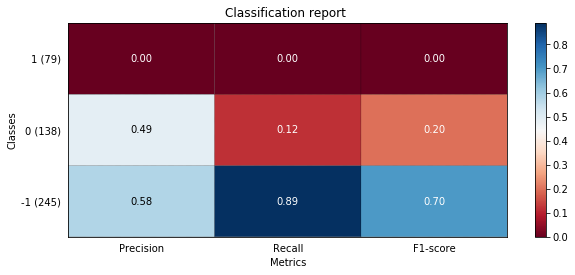

In [48]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_val_predicted_labels_tfidf, target_names= [ "-1","0","1"]))

### On body:

In [72]:
y_val_predicted_labels_tfidf = clf_multilabel.predict(X_val_tfidf)
1accuracy_score(y_val, y_val_predicted_labels_tfidf)

SyntaxError: invalid syntax (<ipython-input-72-0fb50b9f78a0>, line 2)

In [71]:
1plot_classification_report(sklearn.metrics.classification_report(y_val, y_val_predicted_labels_tfidf, target_names= [ "-1","0","1"]))

SyntaxError: invalid syntax (<ipython-input-71-62016907874e>, line 1)

## try with word embeddings:

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import gensim



import nltk
from collections import defaultdict

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from micromort.datasets.risk_dataset import RiskDataset
from gensim.models import KeyedVectors

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [61]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.KeyedVectors.load_word2vec_format("/home/mannu/code/work/micromort/data/wordEmbeddings/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin", binary=True)
        #model = KeyedVectors.load_word2vec_format("/home/mannu/data/wordEmbeddings/word2v.txt")
        #gensim.models.Word2Vec.load("/home/mannu/data/wordEmbeddings/word2v.txt")
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [62]:
w2v = get_word2vec("","/home/mannu/code/work/micromort/data/wordEmbeddings/glove.6B.300d.txt")

Found /home/mannu/code/work/micromort/data/wordEmbeddings/glove.6B.300d.txt


In [63]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [64]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [65]:
data = data_dump[["text", "polarity"]].dropna()

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(data["text"].values, data["polarity"].values)

## Data pre processing

In [67]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/mannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1368,), (1368,), (456,), (456,))

In [69]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_test, text_prepare, 8, 8)

In [74]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [75]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [76]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

('number of features: ', (1368, 75850), (456, 75850))


In [82]:
mean_embedded_train = mean_embedding_vectorizer.fit_transform(X_train)
mean_embedded_test = mean_embedding_vectorizer.fit_transform(X_val)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [87]:
print(mean_embedded_train.shape, mean_embedded_test.shape, Y_train.shape)

((1368, 300), (456, 300), (1368,))


In [88]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(mean_embedded_train, Y_train).predict(mean_embedded_test)
accuracy_score(Y_test, y_pred_svm)

0.7368421052631579

### Try tfidf embeddings

In [89]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)



class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.syn0[0])
        print(self.dim)

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [90]:
tfidf_embedding_vectorizer = TfidfEmbeddingVectorizer(w2v)
tfidf_embedding_vectorizer.fit(X_train)
tfidf_embedded_train = tfidf_embedding_vectorizer.transform(X_train)
tfidf_embedded_test = tfidf_embedding_vectorizer.transform(X_val)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


300


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [92]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(tfidf_embedded_train, Y_train).predict(tfidf_embedded_test)
accuracy_score(Y_test, y_pred_svm)

0.6644736842105263